# Goal

To develop a Machine Learning model that predicts performance degradation and potential failures in solar panels using historical and real-time sensor data, enabling predictive maintenance and optimal energy output.

In [49]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_selection import mutual_info_regression

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.model_selection import cross_val_score, cross_validate

In [4]:
train_df = pd.read_csv("datasets/train.csv")
test_df = pd.read_csv("datasets/test.csv")

# Exploratory Data Analysis

In [5]:
train_df.head()

,id,temperature,irradiance,humidity,panel_age,maintenance_count,soiling_ratio,voltage,current,module_temperature,cloud_coverage,wind_speed,pressure,string_id,error_code,installation_type,efficiency
0,0,7.817315,576.179270,41.24308670850264,32.135501,4.0,0.803199,37.403527,1.963787,13.691147,62.494044,12.82491203459621,1018.8665053152533,A1,NaN,NaN,0.562096
1,1,24.785727,240.003973,1.3596482765960705,19.977460,8.0,0.479456,21.843315,0.241473,27.545096,43.851238,12.012043660984917,1025.6238537572883,D4,E00,dual-axis,0.396447
2,2,46.652695,687.612799,91.26536837560256,1.496401,4.0,0.822398,48.222882,4.191800,43.363708,NaN,1.814399755560454,1010.9226539809573,C3,E00,NaN,0.573776
3,3,53.339567,735.141179,96.19095521176159,18.491582,3.0,0.837529,46.295748,0.960567,57.720436,67.361473,8.736258932034128,1021.8466633134253,A1,NaN,dual-axis,0.629009
4,4,5.575374,12.241203,27.495073003585226,30.722697,6.0,0.551833,0.000000,0.898062,6.786263,3.632000,0.52268384077164,1008.5559577591927,B2,E00,fixed,0.341874


In [6]:
train_df.shape

(20000, 17)

In [7]:
train_df.describe()

,id,temperature,irradiance,panel_age,maintenance_count,soiling_ratio,voltage,current,module_temperature,cloud_coverage,efficiency
count,20000.000000,18999.000000,19013.000000,18989.000000,18973.000000,18990.000000,19007.000000,19023.000000,19022.000000,18990.000000,20000.000000
mean,9999.500000,25.077241,501.273896,17.509758,4.012070,0.698879,16.242251,1.713396,29.923807,51.378575,0.510260
std,5773.647028,12.513129,250.926590,10.097557,2.002268,0.172244,17.889031,1.152953,12.125405,48.473664,0.140420
min,0.000000,0.000000,-597.278646,0.001264,0.000000,0.400149,0.000000,0.000054,0.000000,0.000244,0.000000
25%,4999.750000,16.853522,332.227277,8.777905,3.000000,0.550654,0.000000,0.772311,21.522124,25.081618,0.445613
50%,9999.500000,24.720345,499.654730,17.497731,4.000000,0.697663,12.350138,1.558413,29.857669,49.704133,0.515709
75%,14999.250000,32.848917,668.416734,26.340761,5.000000,0.847838,26.557322,2.474744,38.094943,75.052824,0.590324
max,19999.000000,147.394168,1537.810349,34.998379,15.000000,0.999949,494.279016,7.315597,65.000000,1000.000000,0.987066


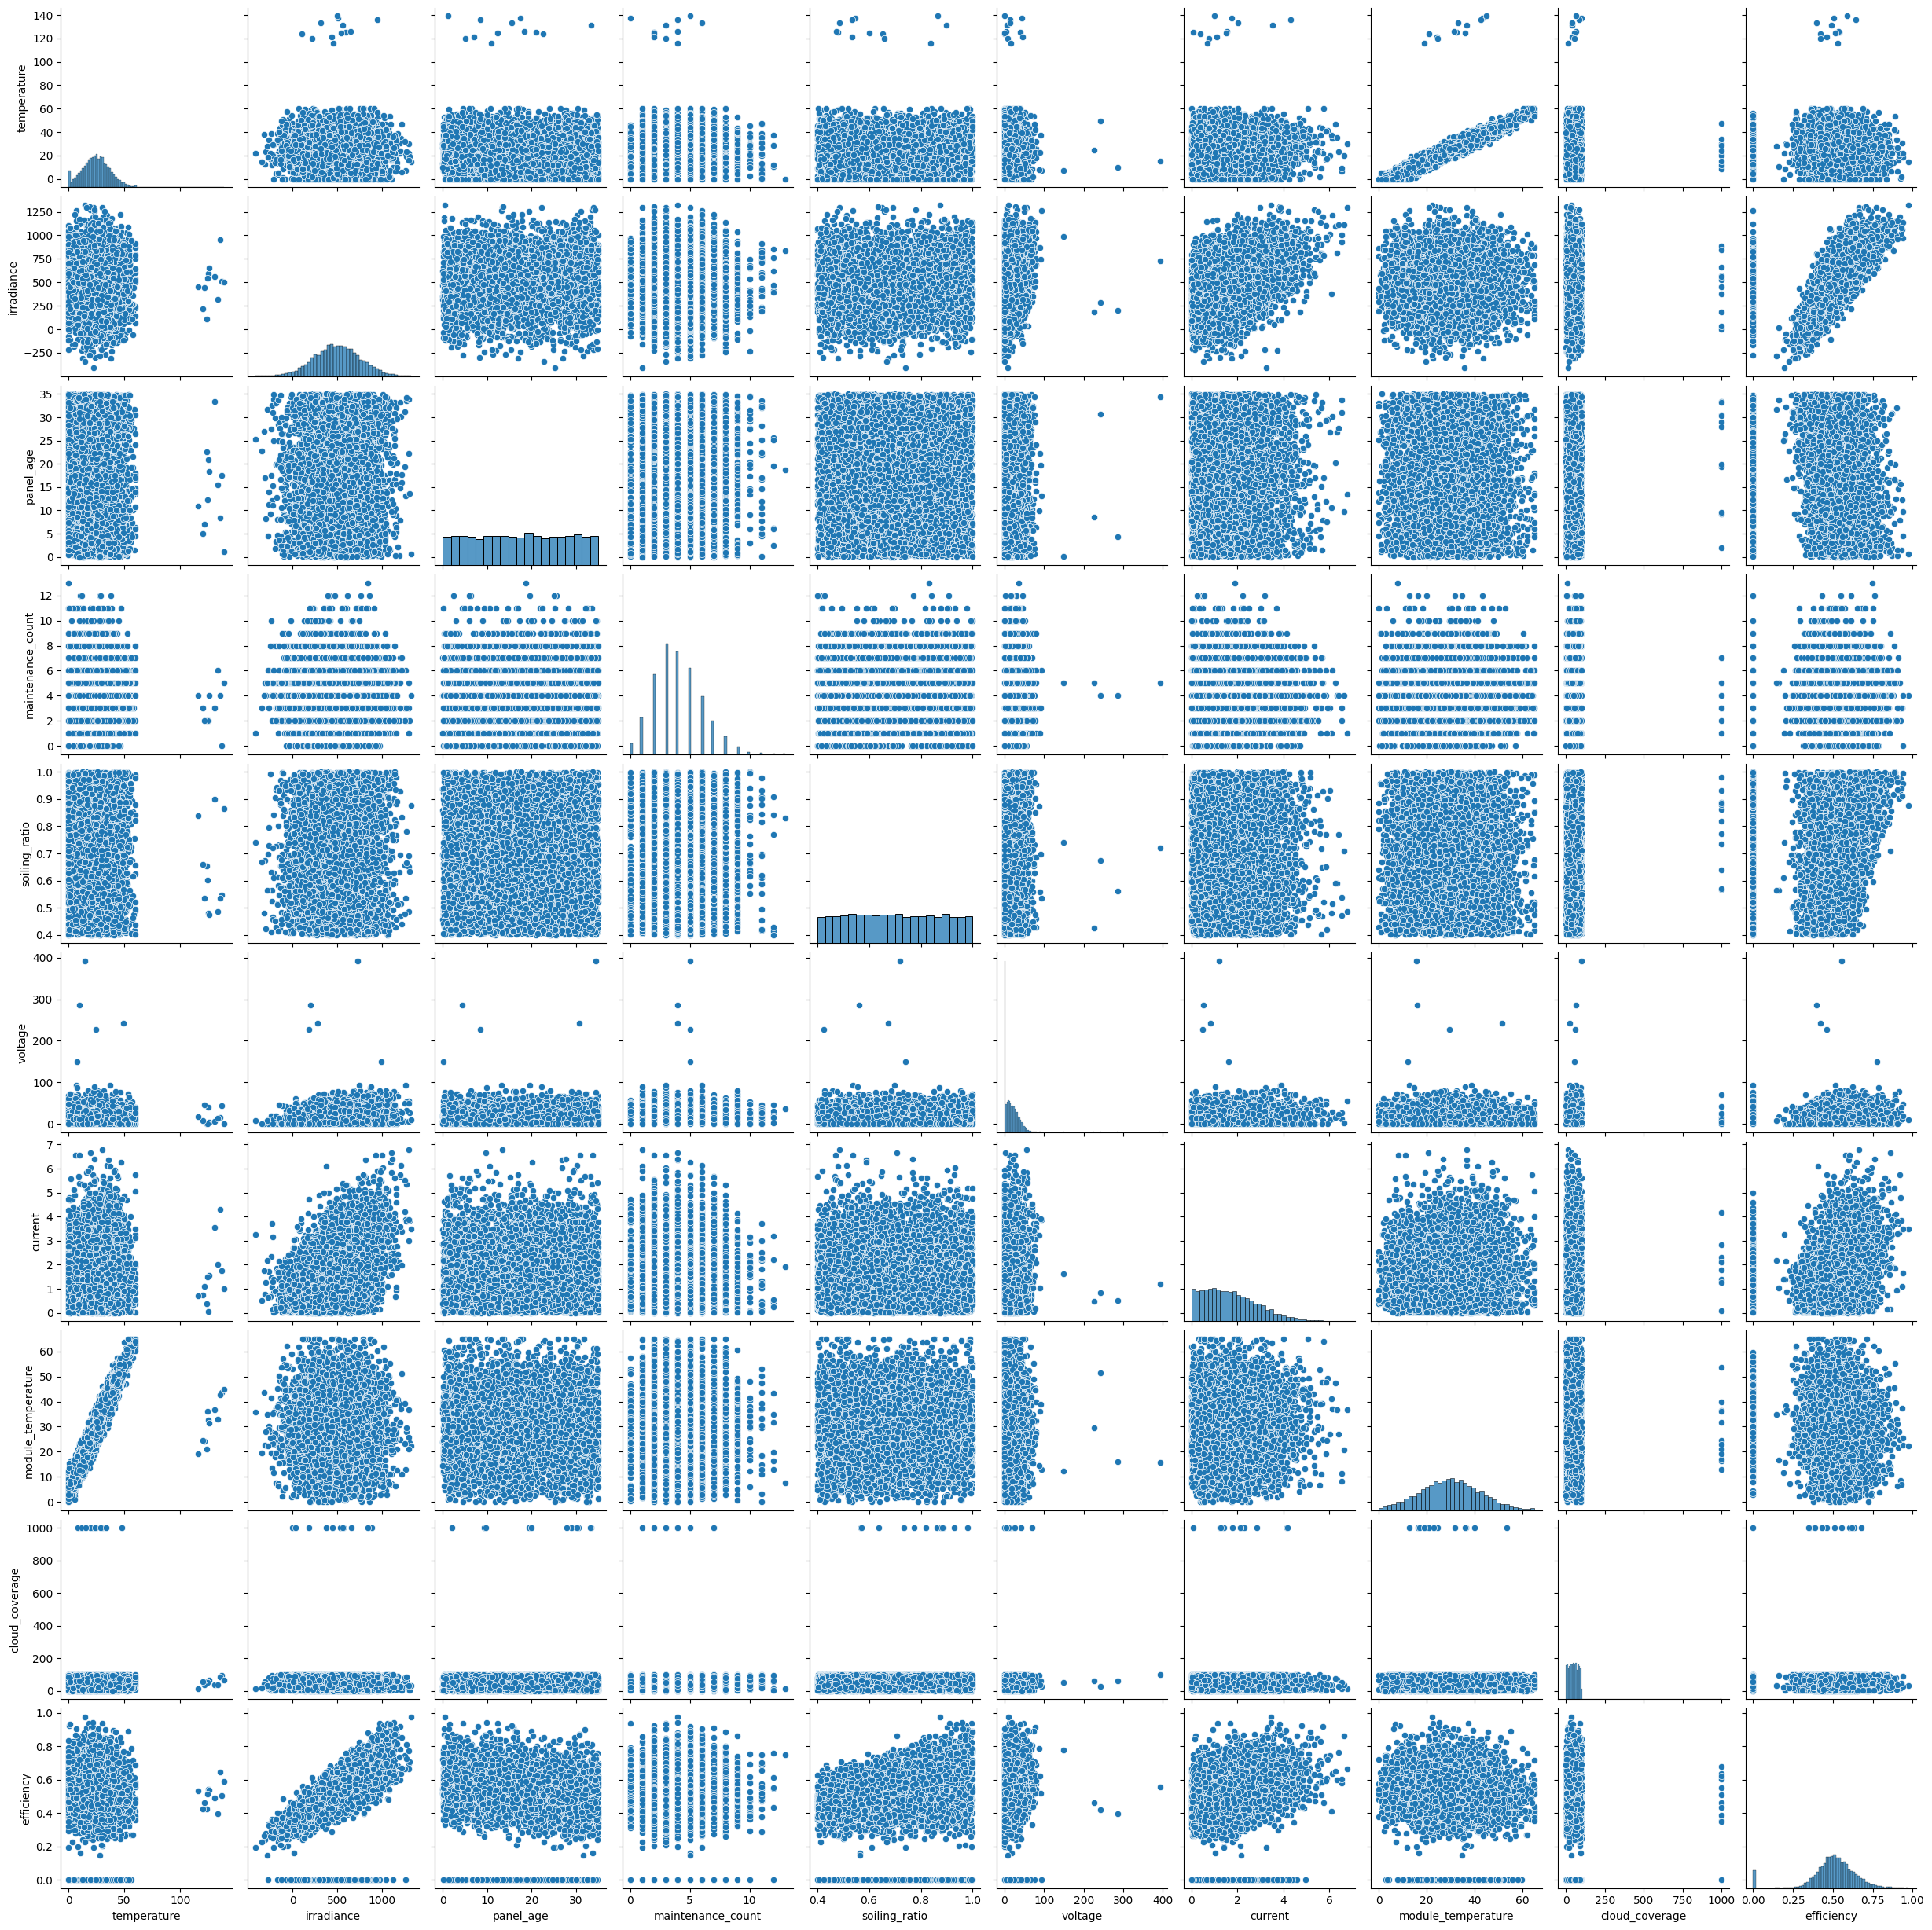

In [8]:
sns.pairplot(train_df.dropna().drop(columns="id"))

## Data Types

In [9]:
train_df.dtypes

id                      int64
temperature           float64
irradiance            float64
humidity               object
panel_age             float64
maintenance_count     float64
soiling_ratio         float64
voltage               float64
current               float64
module_temperature    float64
cloud_coverage        float64
wind_speed             object
pressure               object
string_id              object
error_code             object
installation_type      object
efficiency            float64
dtype: object

### Fix data types

In [10]:
change_dtype = ["humidity", "wind_speed", "pressure"]
for col in change_dtype:
    train_df[col] = pd.to_numeric(train_df[col], errors='coerce')

In [11]:
train_df.dtypes

id                      int64
temperature           float64
irradiance            float64
humidity              float64
panel_age             float64
maintenance_count     float64
soiling_ratio         float64
voltage               float64
current               float64
module_temperature    float64
cloud_coverage        float64
wind_speed            float64
pressure              float64
string_id              object
error_code             object
installation_type      object
efficiency            float64
dtype: object

## Feature Selection

### Numerical features

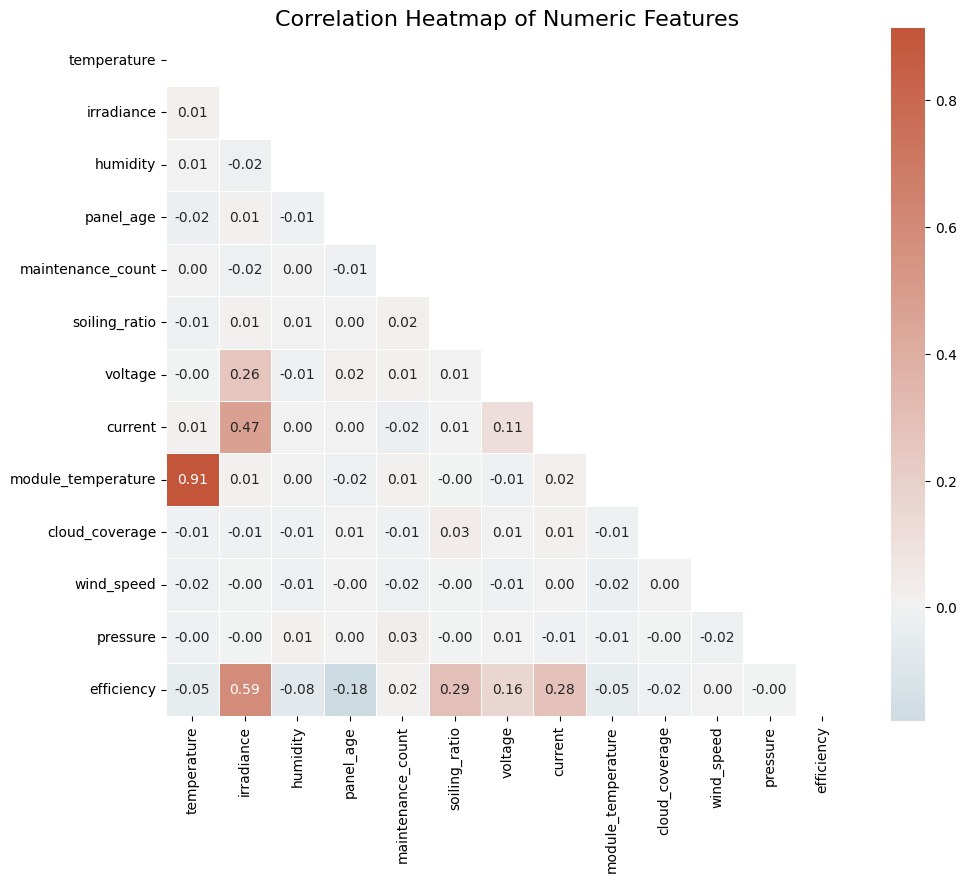

In [12]:
corr = train_df.dropna().select_dtypes(include="number").drop(columns="id").corr()

mask = np.triu(np.ones_like(corr, dtype=bool))
f, ax = plt.subplots(figsize=(11, 9))

cmap = sns.diverging_palette(230, 20, as_cmap=True)

sns.heatmap(
    corr,
    mask=mask, 
    cmap=cmap,
    center=0,
    annot=True,         
    fmt=".2f",          
    linewidths=.5,      
    cbar=True,          
    square=True         
)

plt.title('Correlation Heatmap of Numeric Features', fontsize=16)
plt.show()

In [13]:
x_num = train_df.dropna().select_dtypes(include="number").drop(columns=["id", "efficiency"])
y = train_df.dropna()["efficiency"]

In [14]:
mi_scores = mutual_info_regression(x_num, y)
mi_scores = [float(i) for i in mi_scores]

In [15]:
feat_imp = dict(zip(x_num.columns, mi_scores))

In [16]:
sorted_feat_imp = sorted(feat_imp.items(), key=lambda item: item[1], reverse=True)
sorted_feat_imp = dict(sorted_feat_imp)

In [17]:
sorted_feat_imp

{'irradiance': 0.4812553776882922,
 'soiling_ratio': 0.09772243132943448,
 'current': 0.07111963518635811,
 'panel_age': 0.02862619590610116,
 'voltage': 0.027255573317162884,
 'humidity': 0.01881144774511423,
 'cloud_coverage': 0.01794458305583735,
 'wind_speed': 0.0020038047838744077,
 'temperature': 0.0,
 'maintenance_count': 0.0,
 'module_temperature': 0.0,
 'pressure': 0.0}

In [18]:
num_features = ['irradiance','soiling_ratio','current','panel_age','voltage','humidity','cloud_coverage','wind_speed']

### Categorical features

In [21]:
cat_features = ["string_id","error_code","installation_type"]

string_id
D4    5080
B2    5014
C3    5004
A1    4902
Name: count, dtype: int64


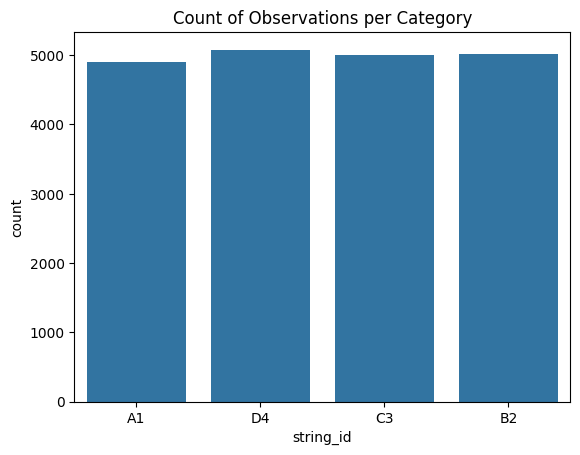

error_code
E00    5977
E01    4100
E02    4011
Name: count, dtype: int64


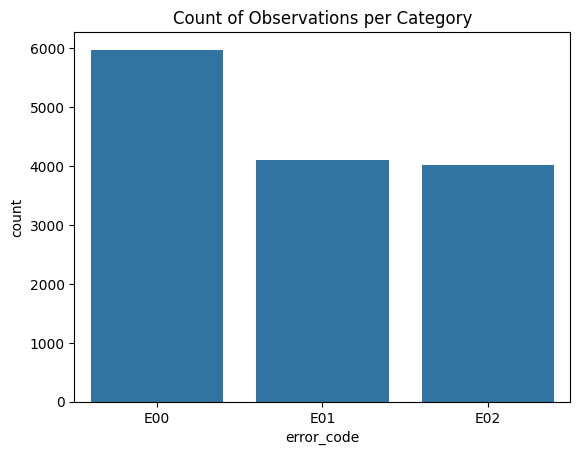

installation_type
tracking     5067
fixed        4990
dual-axis    4915
Name: count, dtype: int64


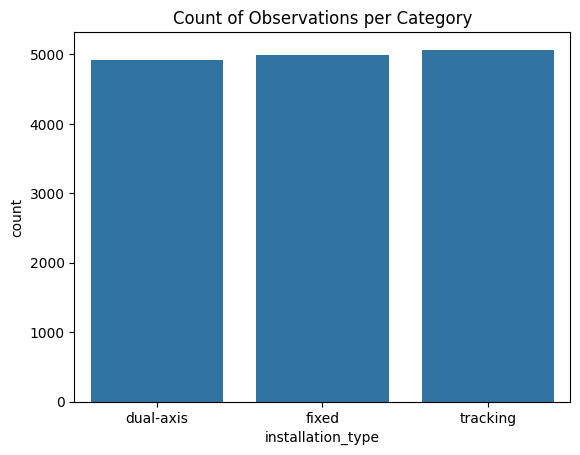

In [27]:
for cat in cat_features:
    print(train_df[cat].value_counts())
    sns.countplot(x=cat, data=train_df)
    plt.title('Count of Observations per Category')
    plt.show()

In [28]:
train_df_cat = train_df.dropna()[cat_features+["efficiency"]]

In [30]:
train_df_cat.head()

,string_id,error_code,installation_type,efficiency
1,D4,E00,dual-axis,0.396447
4,B2,E00,fixed,0.341874
5,C3,E00,tracking,0.376127
6,A1,E00,fixed,0.537196
7,C3,E01,dual-axis,0.466850


In [86]:
# One-hot encode the categorical features
X_cat = pd.get_dummies(train_df_cat[['string_id', 'error_code', 'installation_type']], drop_first=True)
y_cat = train_df_cat['efficiency']

# Compute mutual information
mi_scores_cat = mutual_info_regression(X_cat, y_cat, discrete_features=True)

# Put results in a DataFrame
mi_results = pd.Series(mi_scores_cat, index=X_cat.columns).sort_values(ascending=False)
print(mi_results)


string_id_D4                  0.005191
string_id_C3                  0.004146
error_code_E02                0.002405
string_id_B2                  0.000000
error_code_E01                0.000000
installation_type_fixed       0.000000
installation_type_tracking    0.000000
dtype: float64


In [87]:
# Create a copy for target encoding
df_te = train_df_cat.copy()

# Encode each categorical variable with mean efficiency
for col in ['string_id', 'error_code', 'installation_type']:
    means = df_te.groupby(col)['efficiency'].mean()
    df_te[col + '_te'] = df_te[col].map(means)

# Correlation matrix
correlations_te = df_te[['string_id_te', 'error_code_te', 'installation_type_te', 'efficiency']].corr()
print(correlations_te['efficiency'].sort_values(ascending=False))


efficiency              1.000000
string_id_te            0.028188
error_code_te           0.013925
installation_type_te    0.003828
Name: efficiency, dtype: float64


- Include all three categorical features in model training.

## Outliers

In [31]:
train_df.loc[train_df['cloud_coverage'] > 100, 'cloud_coverage'] = np.nan
train_df.loc[train_df['temperature'] >= 100, 'temperature'] = np.nan
train_df.loc[train_df['voltage'] > 100, 'voltage'] = np.nan

## Missing Values

In [32]:
# Percentage of missing values
(train_df.isnull().sum() / train_df.shape[0])*100

id                     0.000
temperature            5.175
irradiance             4.935
humidity               0.635
panel_age              5.055
maintenance_count      5.135
soiling_ratio          5.050
voltage                5.035
current                4.885
module_temperature     4.890
cloud_coverage         5.210
wind_speed             0.595
pressure               0.675
string_id              0.000
error_code            29.560
installation_type     25.140
efficiency             0.000
dtype: float64

## Build pipeline

In [68]:
# Numeric preprocessing: impute → scale
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Categorical preprocessing: one-hot
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

# Column transformer
preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, num_features),
    ('cat', categorical_transformer, cat_features)
])

# Final model pipeline
model = Pipeline([
    ('preprocess', preprocessor),
    ('classifier', clf)  
])

In [69]:
lr = LinearRegression()
lasso_reg = Lasso(alpha=0.005)
clf = Ridge ()

In [70]:
X_train, X_test, y_train, y_test = train_test_split( train_df.drop(columns='efficiency'), 
                                                     train_df['efficiency'], 
                                                     test_size=0.20, 
                                                     random_state=42)

In [71]:
cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
score = 100*(1-np.sqrt(-cv_scores.mean()))
score

np.float64(89.59454211604634)

In [ ]:
89.54757414345833

### Observations
- The training set has 17 features (including one target). 
- The complete training set consists of 20,000 instances.
- Temperature is highly correlated to module_temperature
- Seems to have outliers in efficiency, temperature, voltage, and cloud coverage.
- Irradiance has a strong correlation to efficiency.
- I see a correlation between irradiance and current.
- Efficiency and current

### Transformation steps
- Drop id, .....
- Cast to proper dtype
```
change_dtype = ["humidity", "wind_speed", "pressure"]
for col in change_dtype:
    train_df[col] = pd.to_numeric(train_df[col], errors='coerce')
```
- Impute missing values